In [2]:
#SELECTION DEFINITION

THE_BIG_SELECTION = (
    "((Dst_M - D0_M) > 143) & ((Dst_M - D0_M) < 148) & "
    "(K_IPCHI2_OWNPV > 3) & (pi_IPCHI2_OWNPV > 3) & "
    "(K_TRACK_CHI2NDOF < 1.7) & (pi_TRACK_CHI2NDOF < 1.7) & "
    "(K_PT > 250) & (pi_PT > 250) & "
    "(K_hasRich == 1) & (pi_hasRich == 1) & "
    "(mp_TRACK_CHI2NDOF < 2) & "
    "(mm_TRACK_CHI2NDOF < 2) & "
    "(mp_isMuon == 1) & (mm_isMuon == 1) & "
    "(mp_PIDmu > 0) & (mm_PIDmu > 0) & "
    "(mp_PT > 700) & (mm_PT > 700) & "
    "(mp_IPCHI2_OWNPV > 2) & (mm_IPCHI2_OWNPV > 2) & "
    "(Jpsi_M < 3140) & (Jpsi_M > 3040) & "
    "(pi_soft_PT > 250) & "
    "(Bc_ENDVERTEX_CHI2 < 4.2) & "
    "(Bc_IPCHI2_OWNPV < 10) & "
    "(Bc_DIRA_OWNPV > 0.99)"
)


In [3]:
#IMPORTING LIBRARIES
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
import zfit

from xgboost import XGBClassifier, callback, plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import pickle
import optuna
import joblib
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import random 

/Users/khrystina/new_env/lib/python3.11/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/Users/khrystina/new_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#DATA DOWNLOADING
files_simu = [
    './simulation/2011_MagDown.root', 
    './simulation/2015_MagDown.root',
    './simulation/2015_MagUp.root',
    './simulation/2016_MagDown.root',
    './simulation/2016_MagUp.root',
    './simulation/2017_MagDown.root',
    './simulation/2017_MagUp.root',
    './simulation/2018_MagDown.root',
    './simulation/2018_MagUp.root'
]

files_real_data = [
    './real_data/2011_MagDown.root', 
    './real_data/2011_MagUp.root',
    './real_data/2012_MagDown.root', 
    './real_data/2012_MagUp.root',
    './real_data/2015_MagDown.root', 
    './real_data/2015_MagUp.root',
    './real_data/2016_MagDown.root', 
    './real_data/2016_MagUp.root',
    './real_data/2017_MagDown.root', 
    './real_data/2017_MagUp.root',
    './real_data/2018_MagDown.root', 
    './real_data/2018_MagUp.root'
]
simu_data = uproot.concatenate(files_simu, cut = f"{THE_BIG_SELECTION} & (Bc_BKGCAT == 0)", library='pd')
real_data = uproot.concatenate(files_real_data, cut = f"{THE_BIG_SELECTION} & ((Bc_FullDTF_M < 6250.) | (Bc_FullDTF_M > 6300.))", library='pd')
real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_4121/2903014781.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_4121/2903014781.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']


In [5]:
#FUNCTION FOR PLOTTING
def plot_model_with_pulls(model, name, data, min, max, scale=1, nbins=50, plot_data=True):
    
    size_normal = len(data)
    lower, upper = data.data_range.limit1d
    x = np.linspace(lower, upper, num=1000)

    # Evaluate model PDF
    y = model.pdf(x) * size_normal / nbins * data.data_range.volume
    y *= scale
    fig = plt.figure(figsize=(8, 6))

    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05) 

    # Upper subplot: Model and Data with error bars
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(x, y, label="model", color="blue", linewidth=1)
    ax1.set_xlim(min, max)

    if plot_data:
        # Bin the data
        data_binned = data.to_binned(nbins)
        bin_centers = data_binned.axes[0].centers
        bin_widths = data_binned.axes[0].widths
        data_counts = data_binned.values()
        data_uncertainties = np.sqrt(data_counts)  # Poisson errors

        ax1.errorbar(
            bin_centers, data_counts, yerr=data_uncertainties, fmt='o', 
            color='orange', label="data", markersize=1, capsize=2
        )

    ax1.legend()
    ax1.set_ylabel("Counts")
    
    ax1.set_title(name)
    ax1.grid()

    # Lower subplot: Pulls visualization
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    if plot_data:
        # Compute pulls
        model_at_bins = np.array(model.pdf(bin_centers)) * size_normal / nbins * data.data_range.volume

        pulls = (data_counts - model_at_bins) / data_uncertainties

        ax2.errorbar(
            bin_centers, pulls, yerr=1, fmt='o', 
            color='purple', label="pulls", markersize=1, capsize=2
        )
        ax2.axhline(0, color='black', linestyle='--', linewidth=1)
        ax2.set_ylim(-10, 10) 
        ax2.set_ylabel("Pulls")
        ax2.grid()
        ax2.legend()
    ax2.set_xlabel("Observable")
    plt.tight_layout()
    plt.show()

In [6]:
#FUNCTION FOR PLOTTING
def plot_model_with_pulls_log(model, name, data, min, max, scale=1, nbins=50, plot_data=True):
    
    size_normal = len(data)
    lower, upper = data.data_range.limit1d
    x = np.linspace(lower, upper, num=1000)

    # Evaluate model PDF
    y = model.pdf(x) * size_normal / nbins * data.data_range.volume
    y *= scale
    fig = plt.figure(figsize=(8, 6))

    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05) 

    # Upper subplot: Model and Data with error bars
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(x, y, label="model", color="blue", linewidth=1)
    ax1.set_xlim(min, max)

    if plot_data:
        # Bin the data
        data_binned = data.to_binned(nbins)
        bin_centers = data_binned.axes[0].centers
        bin_widths = data_binned.axes[0].widths
        data_counts = data_binned.values()
        data_uncertainties = np.sqrt(data_counts)  # Poisson errors

        ax1.errorbar(
            bin_centers, data_counts, yerr=data_uncertainties, fmt='o', 
            color='orange', label="data", markersize=1, capsize=2
        )

    ax1.legend()
    ax1.set_ylabel("Counts")
    
    ax1.set_title(name)
    ax1.grid()

    # Lower subplot: Pulls visualization
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    if plot_data:
        # Compute pulls
        model_at_bins = model.pdf(bin_centers) * size_normal / nbins * data.data_range.volume
        pulls = (data_counts - model_at_bins) / data_uncertainties

        ax2.errorbar(
            bin_centers, pulls, yerr=1, fmt='o', 
            color='purple', label="pulls", markersize=1, capsize=2
        )
        ax2.axhline(0, color='black', linestyle='--', linewidth=1)
        ax2.set_ylim(-10, 10) 
        ax2.set_ylabel("Pulls")
        ax2.grid()
        ax2.legend()
    ax1.set_yscale('log')
    ax2.set_xlabel("Observable")
    plt.tight_layout()
    plt.show()

In [7]:
#BDT training

feature_columns = [

    'mp_PT',
    'mm_PT',
    'Bc_ENDVERTEX_CHI2',
    'Bc_IPCHI2_OWNPV',

    'Bc_FD_OWNPV',
    'Jpsi_FD_ORIVX',
    'D0_FD_ORIVX'
    ]
#PREPARING DATASET
# Separate features and labels
X_simu = simu_data[feature_columns]
y_simu = np.ones(len(simu_data))  # Label: 1 for simulation data

X_real = real_data[feature_columns]
y_real = np.zeros(len(real_data))  # Label: 0 for real data

# Combine features and labels
X_all = pd.concat([X_simu, X_real], ignore_index=True)
y_all = np.concatenate([y_simu, y_real]) 

print(f"SIMULATION set size: {X_simu.shape}")
print(f"REAL DATA set size: {X_real.shape}")

#TRAINING MODEL WITH K-FOLD AND EARLY STOPPING
from sklearn.preprocessing import LabelEncoder
n_folds = 5
fold_accuracies = []

kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=11)

# Load Optuna-saved model parameters
with open("best_optuna_model.pkl", "rb") as file:
    best_model_params = pickle.load(file)
try:
    print(type(best_model_params))  # Debugging step
    print(best_model_params) 
    if isinstance(best_model_params, XGBClassifier):
        best_model_params = best_model_params.get_params()  # Extract parameters from model
    elif not isinstance(best_model_params, dict):
        raise TypeError(f"Unexpected type for best_model_params: {type(best_model_params)}")

    elif not isinstance(best_model_params, dict):
        raise TypeError("Unexpected type for best_model_params:", type(best_model_params))


except ImportError as e:
    print("ImportError occurred:", e)

# Ensure parameters are valid for XGBClassifier
if hasattr(best_model_params, 'get_params'):
    best_model_params = best_model_params.get_params()


best_model_params.update({
    'random_state': 51, 
    'eval_metric': 'logloss' ,
    'early_stopping_rounds': 20 
})

classif_list = []
# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_all, y_all)):
    print(f"Processing Fold {fold + 1}/{n_folds}...")
    # Initialize the model with the best parameters
    model_es = XGBClassifier(**best_model_params)
    # Split the data using iloc for pandas DataFrame compatibility
    X_train, X_val = X_all.iloc[train_index], X_all.iloc[val_index]
    y_train, y_val = y_all[train_index], y_all[val_index]
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    

    # Fit the model with early stopping
    model_es.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    classif_list.append(model_es)
    # Evaluate the model on the validation set
    y_pred = model_es.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)
    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

mean_accuracy = np.mean(fold_accuracies)
print(f"\nMean Cross-Validation Accuracy: {mean_accuracy:.4f}")

model_es.save_model("best_kfold_early_stopping_model.json")
real_data_predictions = classif_list[1].predict_proba(X_real)[:, 1]
real_data_filtered = real_data[real_data_predictions > 0.9]

#ACCURACY

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=92)

# Predict on the test set
y_pred = classif_list[1].predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

SIMULATION set size: (28209, 7)
REAL DATA set size: (2594, 7)
<class 'xgboost.sklearn.XGBClassifier'>
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.057345347578566394, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=233, n_jobs=None,
              num_parallel_tree=None, random_state=52, ...)
Processing Fold 1/5...
Fold 1 Accuracy: 0.9456
Processing Fold 2/5...
Fold 2 Accuracy: 0.9403
Processing Fold 3

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_4121/1815706554.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


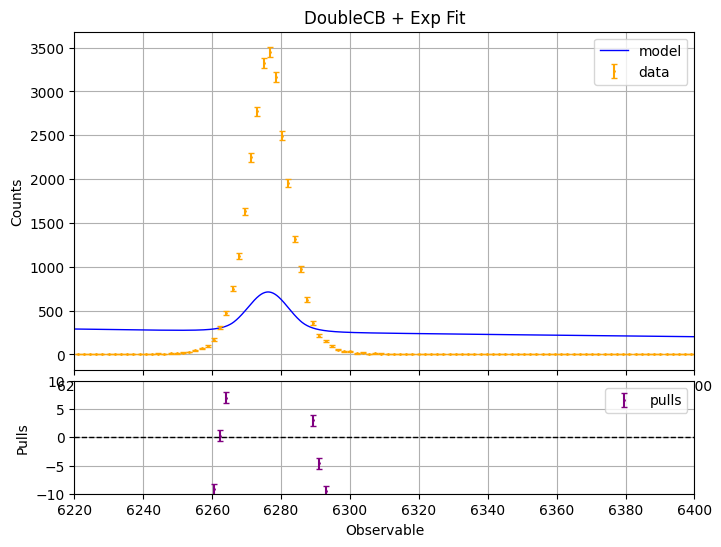

28686


In [8]:
#CREATING INITIAL MODEL
from matplotlib.gridspec import GridSpec 

simu_mass = simu_data['Bc_FullDTF_M']
simu_mass_np = simu_mass.to_numpy()

mass_values = real_data_filtered['Bc_FullDTF_M'].values  
mass_obs = zfit.Space('Bc_FullDTF_M', limits=(6220, 6400))
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

mu_dcb = zfit.Parameter('mu_dcb', 6276.28, 6259, 6290, floating=False)
sigma_dcb = zfit.Parameter('sigma_dcb', 5.86, 1.1, 19, floating=False)
alpha_dcb_l = zfit.Parameter('alpha_dcb_l', 1.7, 0.1, 5, floating=False)
n_dcb_l = zfit.Parameter('n_dcb_l', 7.77, 5.1, 50, floating=False)
alpha_dcb_r = zfit.Parameter('alpha_dcb_r', 1.61, 0.1, 5, floating=False)
n_dcb_r = zfit.Parameter('n_dcb_r', 11.7, 7.1, 15, floating=False)

dcb = zfit.pdf.DoubleCB(obs=mass_obs, mu=mu_dcb, sigma=sigma_dcb, 
                        alphal=alpha_dcb_l, nl=n_dcb_l, 
                        alphar=alpha_dcb_r, nr=n_dcb_r)

N_sig = zfit.Parameter("N_sig", 13, 0, 1e6, floating=False)
dcb_extended = dcb.create_extended(N_sig)

lambda_param = zfit.Parameter("lambda", -0.002, -0.04, -0.0001, floating=False)
exp_pdf = zfit.pdf.Exponential(lambda_param, obs=mass_obs)

N_bkg = zfit.Parameter("N_bkg", 82.2, 0, 1e6, floating=False)
exp_pdf_extended = exp_pdf.create_extended(N_bkg)

supermodel = zfit.pdf.SumPDF([dcb_extended, exp_pdf_extended])

combined_mass = np.concatenate([simu_mass_np, mass_values])  
combined_data = zfit.Data.from_numpy(obs=mass_obs, array=combined_mass)

nll = zfit.loss.UnbinnedNLL(model=supermodel, data=combined_data)

minimizer = zfit.minimize.Minuit()
# result = minimizer.minimize(loss=nll)

plot_model_with_pulls(supermodel, "DoubleCB + Exp Fit", combined_data, 6220, 6400, nbins=100)

# print(result)
print(len(simu_mass)+len(mass_values))


In [9]:
#CREATING FAKE DATASETS
def generate_fake_data(n_samples = 'extended'):
    return supermodel.sample(n=n_samples)

n_experiments=300
datasets = []
for _ in range(n_experiments):
    fake_data = generate_fake_data()
    datasets.append(fake_data)



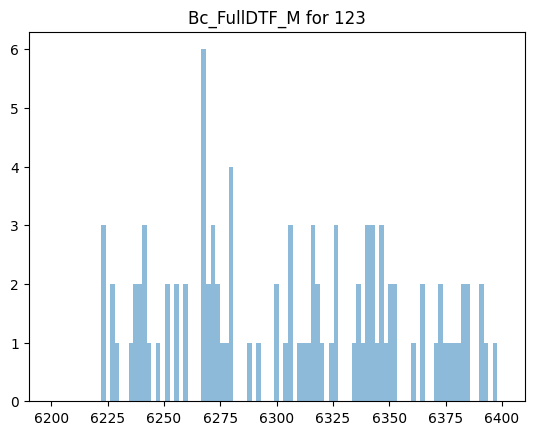

In [11]:
#CHEKING Bc_FullDTF_M DISTRIBUTION
i = random.randint(1, 300)
nbins = 100
bins = np.linspace(6200, 6400, nbins)
bin_width = (6400 - 6200) / nbins

hist, bin_edges = np.histogram(mass_values, bins=bins)
plt.hist(datasets[i]['Bc_FullDTF_M'], bins=bins, alpha=0.5, label="Data")
plt.title(f"Bc_FullDTF_M for {i}")
plt.show()

In [12]:
#CREATING FLOATING MODEL
def creating_model ():
    mass_values = real_data_filtered['Bc_FullDTF_M'].values  
    mass_obs = zfit.Space('Bc_FullDTF_M', limits=(6220, 6400))
    simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

    shift_mu = zfit.Parameter('shift_mu', 0, -12, 12)
    scale_sigma = zfit.Parameter('scale_sigma', 1., 0.1, 1.9)

    mu_base = zfit.Parameter('mu_base', 6276.28, 6259, 6290, floating=False)
    mu = zfit.ComposedParameter('mu', lambda mu, shift: mu + shift, params=[mu_base, shift_mu])

    sigma_base = zfit.Parameter('sigma_base', 5.86, 1.1, 19, floating=False)
    sigma = zfit.ComposedParameter('sigma', lambda sigma, scale: sigma * scale, params=[sigma_base, scale_sigma])

    alpha_dcb_l = zfit.Parameter('alpha_dcb_l', 1.7, 0.1, 5, floating=False)
    n_dcb_l = zfit.Parameter('n_dcb_l', 7.77, 5.1, 50, floating=False)
    alpha_dcb_r = zfit.Parameter('alpha_dcb_r', 1.61, 0.1, 5, floating=False)
    n_dcb_r = zfit.Parameter('n_dcb_r', 11.7, 7.1, 15, floating=False)

    dcb = zfit.pdf.DoubleCB(obs=mass_obs, mu=mu, sigma=sigma, 
                            alphal=alpha_dcb_l, nl=n_dcb_l, 
                            alphar=alpha_dcb_r, nr=n_dcb_r)

    N_sig = zfit.Parameter("N_sig", 13, 0, 1e6, floating=True)
    dcb_extended = dcb.create_extended(N_sig)

    lambda_param = zfit.Parameter("lambda", -0.002, -0.04, -0.0001, floating=True)
    exp_pdf = zfit.pdf.Exponential(lambda_param, obs=mass_obs)

    N_bkg = zfit.Parameter("N_bkg", 82, 0, 1e6, floating=True)
    exp_pdf_extended = exp_pdf.create_extended(N_bkg)

    floating_model = zfit.pdf.SumPDF([dcb_extended, exp_pdf_extended])

    combined_mass = np.concatenate([simu_mass_np, mass_values])  
    combined_data = zfit.Data.from_numpy(obs=mass_obs, array=combined_mass)

    # plot_model_with_pulls(floating_model, "DoubleCB + Exp Fit", combined_data, 6220, 6400, nbins=100)

    # print(result)
    # print(len(simu_mass)+len(mass_values))
    return floating_model

<Figure size 1200x600 with 0 Axes>

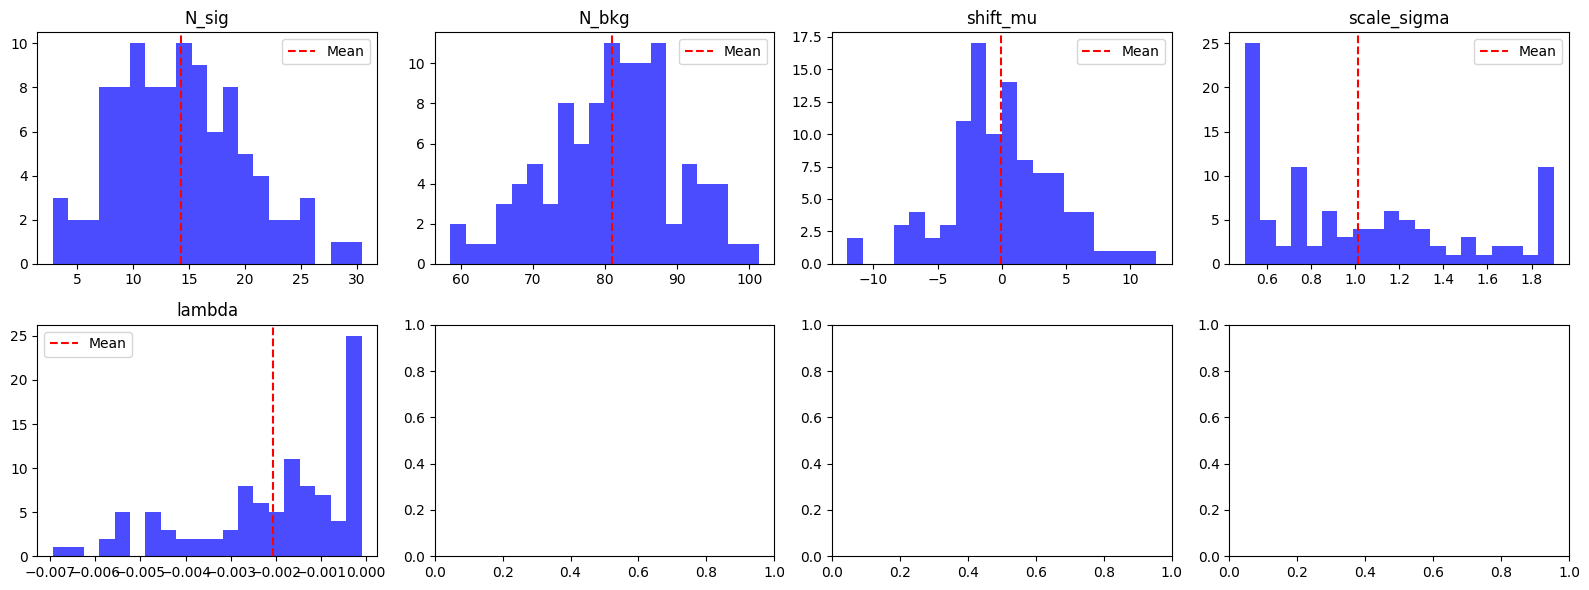

In [84]:
#THESE DATASETS TESTING:

n = 300
fit_results = []
floating_models = []

for i in range(n):
    floating_model = creating_model()
    nll = zfit.loss.ExtendedUnbinnedNLL(model=floating_model, data=datasets[i]['Bc_FullDTF_M'])
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(loss=nll)
    fit_results.append(result)
    
param_values = {param.name: [] for param in floating_model.get_params()}    
for result in fit_results:
    params = result.params
    for param, values in params.items():
        param_values[param.name].append(values["value"])

plt.figure(figsize=(12, 6))

n_params = len(param_values)
n_cols = min(n_params, 4) 
n_rows = (n_params + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten() 

for i, (param, values) in enumerate(param_values.items()):
    ax = axes[i]
    ax.hist(values, bins=20, alpha=0.7, color='blue')
    ax.axvline(np.mean(values), color='red', linestyle='dashed', label='Mean')
    ax.set_title(param)
    ax.legend()

plt.tight_layout()
plt.show()


In [35]:
# Extract fitted N_sig value and uncertainty
N_sig_param = fit_results[1].params["N_sig"]  # This is a dictionary
N_sig_value = N_sig_param["value"]  # Extract the value from the dictionary

# Access the error using the stored errors in param_errors
N_sig_error = param_errors["N_sig"][1]  # Ensure this index is valid or choose the correct one

# Compute significance
SIGNIFICANCE = (N_sig_value) / N_sig_error
print(f"Significance: {SIGNIFICANCE}")


Significance: 2.3843158363671


<Figure size 1200x600 with 0 Axes>

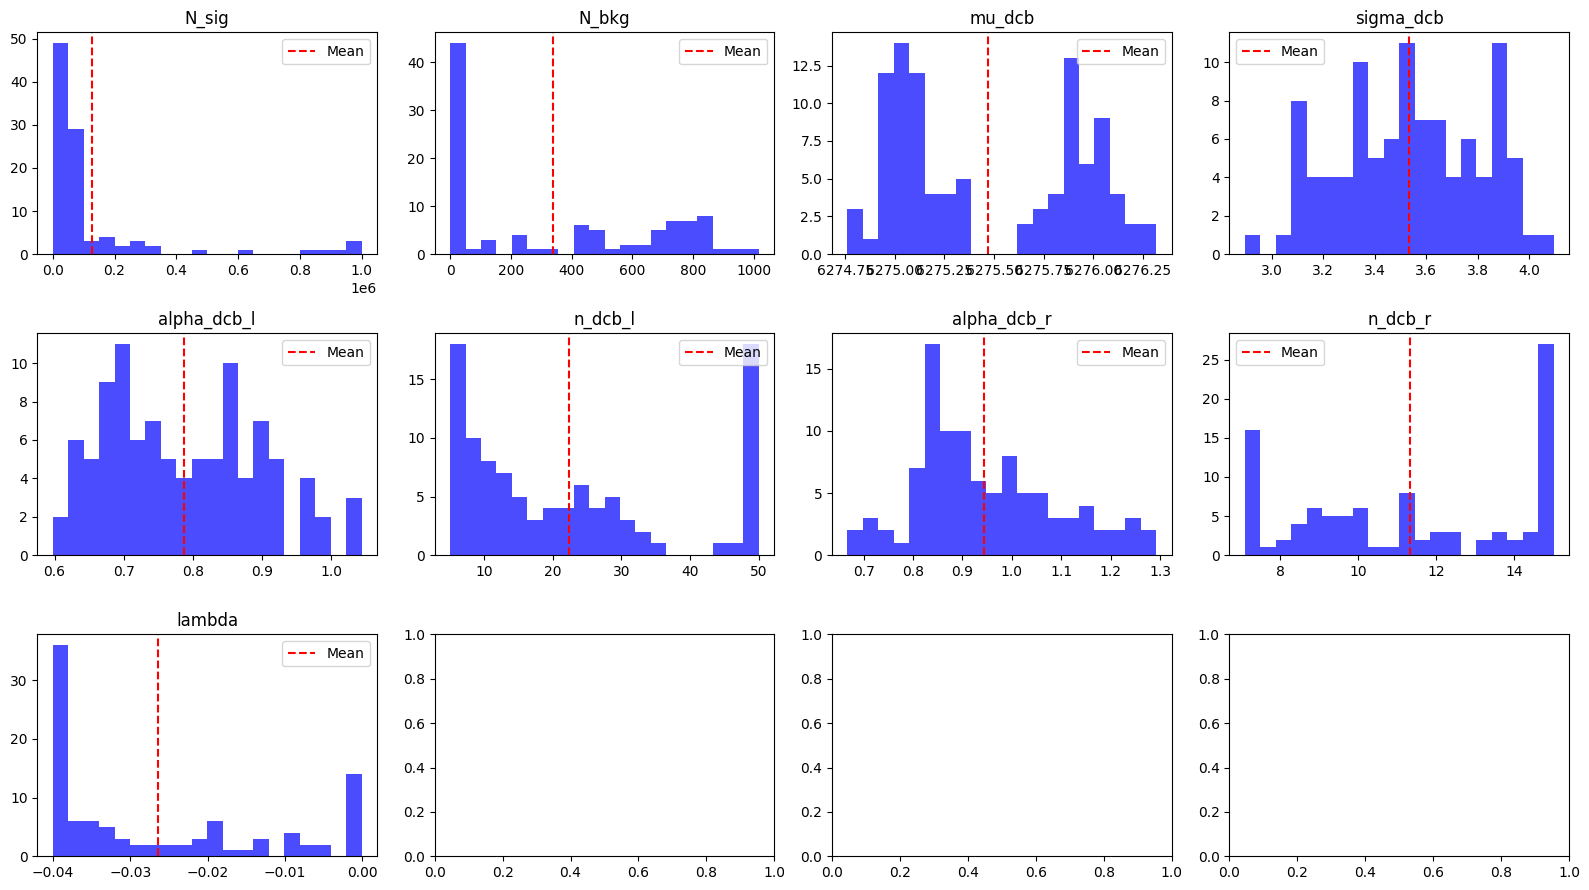

In [20]:
#FAKE DATA TESTING
def generate_fake_data(n_samples=10000):
    return supermodel.sample(n=n_samples)

def fit_and_store_results(n_experiments=100):
    fit_results = []
    for _ in range(n_experiments):
        fake_data = generate_fake_data()
        nll = zfit.loss.UnbinnedNLL(model=supermodel, data=fake_data)
        minimizer = zfit.minimize.Minuit()
        result = minimizer.minimize(loss=nll)
        fit_results.append(result)
    
    return fit_results

def analyze_fit_results(fit_results):
    param_values = {param.name: [] for param in supermodel.get_params()}
    
    for result in fit_results:
        params = result.params
        for param, values in params.items():
            param_values[param.name].append(values["value"])


    plt.figure(figsize=(12, 6))

    n_params = len(param_values)
    n_cols = min(n_params, 4) 
    n_rows = (n_params + n_cols - 1) // n_cols 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = axes.flatten() 

    for i, (param, values) in enumerate(param_values.items()):
        ax = axes[i]
        ax.hist(values, bins=20, alpha=0.7, color='blue')
        ax.axvline(np.mean(values), color='red', linestyle='dashed', label='Mean')
        ax.set_title(param)
        ax.legend()

    plt.tight_layout()
    plt.show()

fit_results = fit_and_store_results(n_experiments=100)
analyze_fit_results(fit_results)


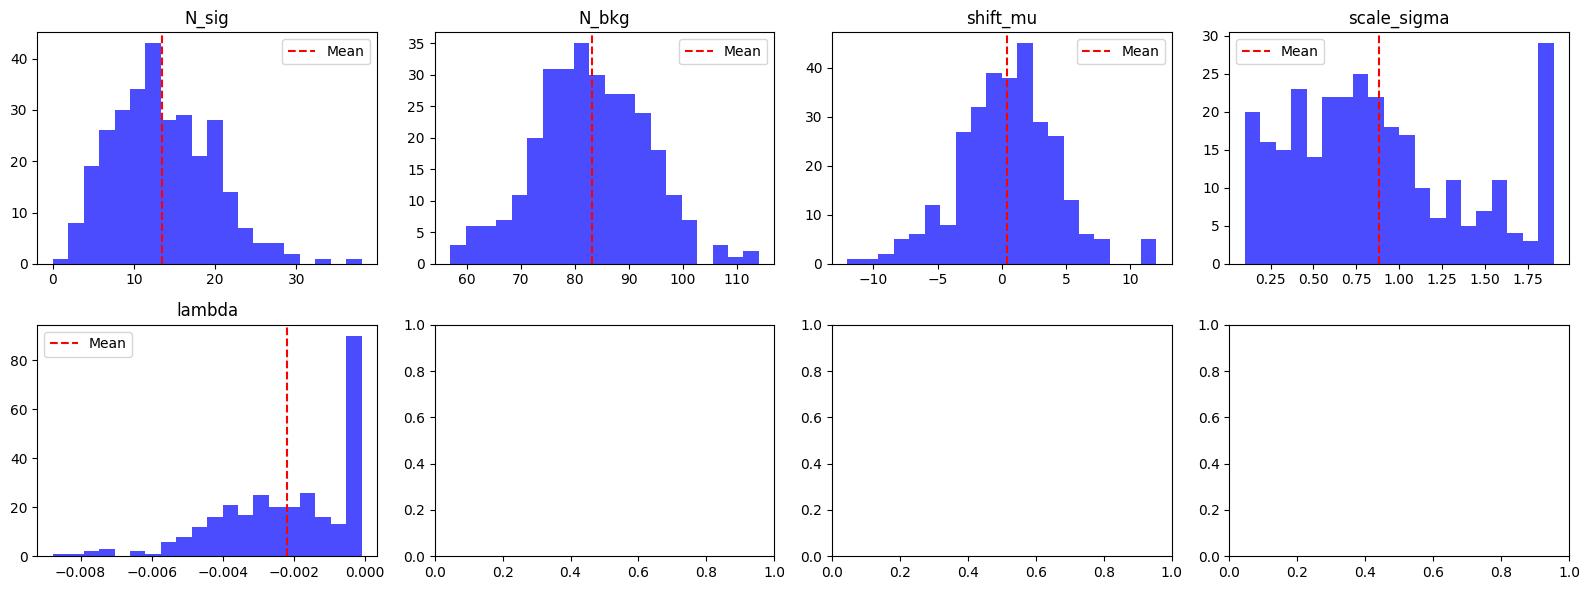

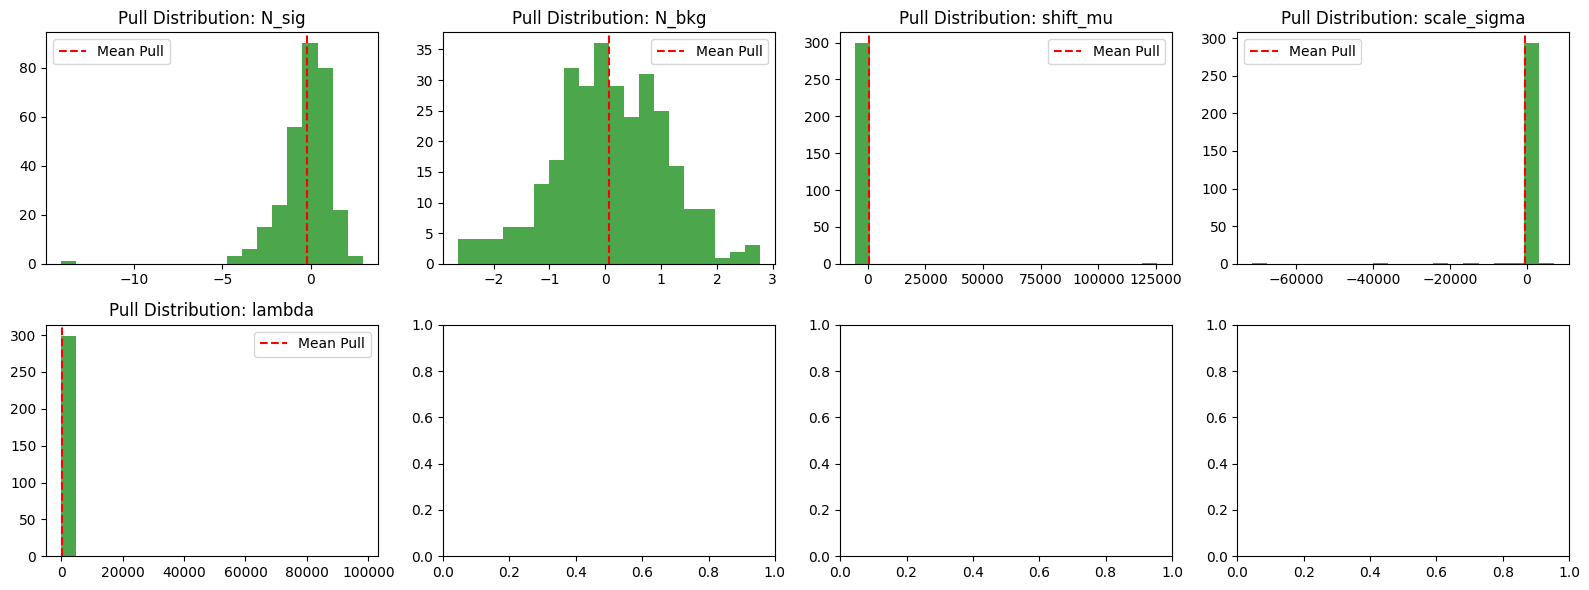

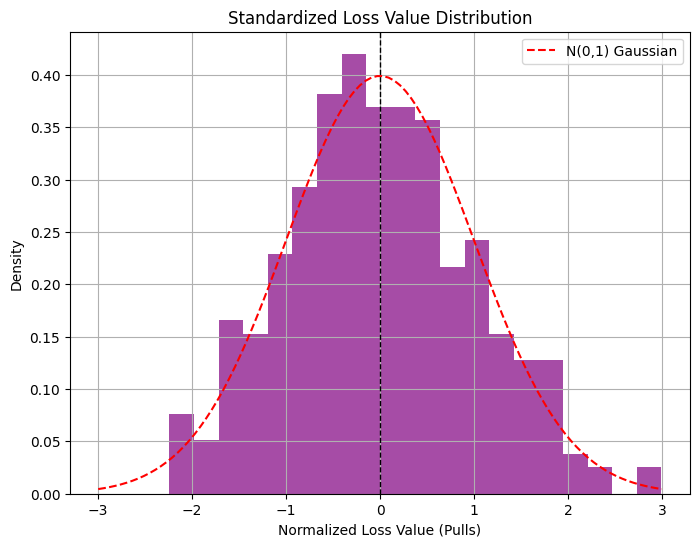

In [13]:

true_params = {
    "shift_mu": 0.,
    "scale_sigma": 1.,
    "mu_base": 6276.28,
    "sigma_base": 5.86,
    "alpha_dcb_l": 1.7,
    "n_dcb_l": 7.77,
    "alpha_dcb_r": 1.61,
    "n_dcb_r": 11.7,
    "N_sig": 13,
    "N_bkg": 82,
    "lambda": -0.002
}


n = 300 # Number of experiments
fit_results = []
floating_models = []
loss_values = []  # To store loss values
param_values = {}
param_errors = {}

# True parameter values from supermodel (assuming they exist)
# true_params = {param.name: param.numpy() for param in supermodel.get_params()}

# Perform the fits and store results
for i in range(n):
    floating_model = creating_model()
    nll = zfit.loss.ExtendedUnbinnedNLL(model=floating_model, data=datasets[i]['Bc_FullDTF_M'])
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(loss=nll)
    
    fit_results.append(result)
    loss_values.append(result.loss.value())

    # Store parameter values and errors
    if i == 0:  # Initialize storage on first iteration
        param_values = {param.name: [] for param in floating_model.get_params()}
        param_errors = {param.name: [] for param in floating_model.get_params()}

    hesse_errors = result.hesse()
    params = result.params
    for param, values in params.items():
        param_values[param.name].append(values["value"])
        param_errors[param.name].append(hesse_errors[param]["error"])  # Use hesse output


# Calculate pulls
pulls = {
    param: [(param_values[param][i] - true_params[param]) / param_errors[param][i]
            for i in range(n)]
    for param in param_values
}

# Plot parameter distributions
n_params = len(param_values)
n_cols = min(n_params, 4)
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, (param, values) in enumerate(param_values.items()):
    ax = axes[i]
    ax.hist(values, bins=20, alpha=0.7, color='blue')
    ax.axvline(np.mean(values), color='red', linestyle='dashed', label='Mean')
    ax.set_title(param)
    ax.legend()

plt.tight_layout()
plt.show()

# Plot Pull Distributions
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, (param, values) in enumerate(pulls.items()):
    ax = axes[i]
    ax.hist(values, bins=20, alpha=0.7, color='green')
    ax.axvline(np.mean(values), color='red', linestyle='dashed', label='Mean Pull')
    ax.set_title(f"Pull Distribution: {param}")
    ax.legend()

plt.tight_layout()
plt.show()

# Plot Loss Values
# Normalize loss values (if necessary)
loss_mean = np.mean(loss_values)
loss_std = np.std(loss_values)
loss_pulls = [(l - loss_mean) / loss_std for l in loss_values]  # Standardized

# Plot Normalized Loss Distribution
plt.figure(figsize=(8, 6))
plt.hist(loss_pulls, bins=20, alpha=0.7, color='purple', density=True)

# Overlay a standard Gaussian for reference
x = np.linspace(-3, 3, 100)
plt.plot(x, np.exp(-x**2 / 2) / np.sqrt(2 * np.pi), color="red", linestyle="dashed", label="N(0,1) Gaussian")

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Normalized Loss Value (Pulls)")
plt.ylabel("Density")
plt.title("Standardized Loss Value Distribution")
plt.legend()
plt.grid()
plt.show()



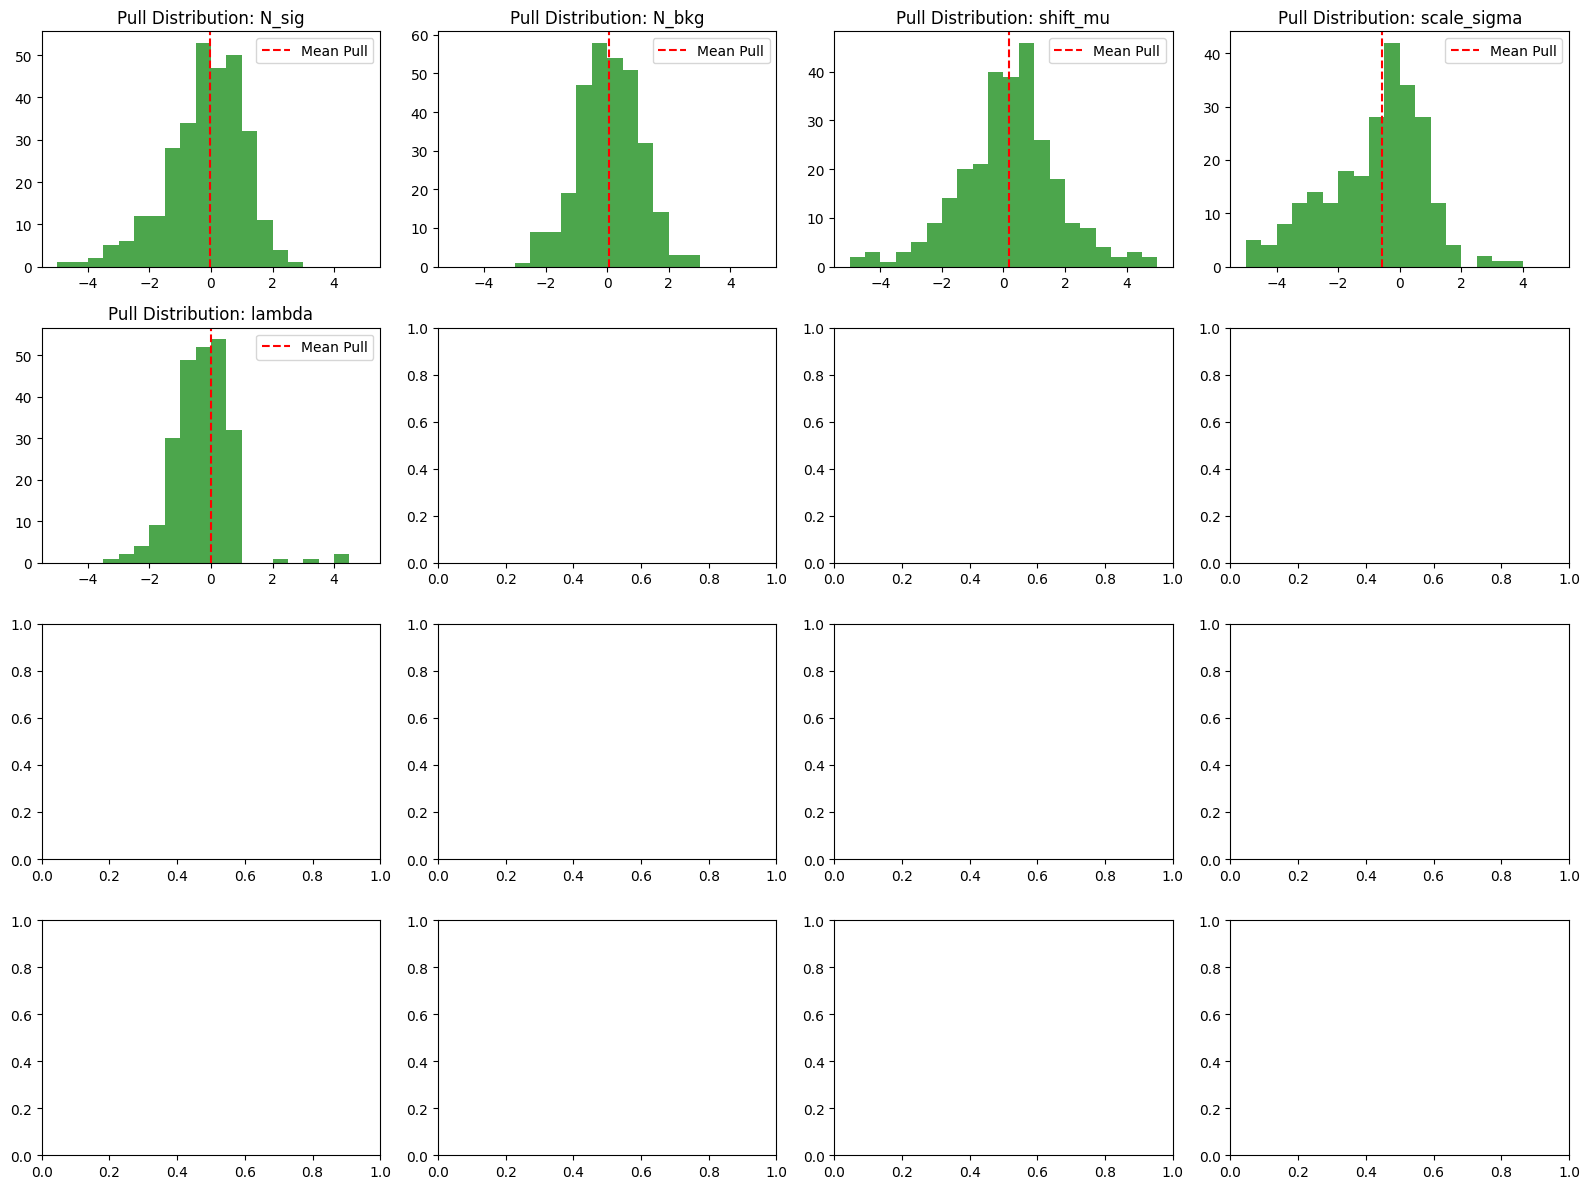

In [17]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, (param, values) in enumerate(pulls.items()):
    ax = axes[i]
    ax.hist(values, bins=20, alpha=0.7, color='green', range = (-5, 5))
    ax.axvline(np.median(values), color='red', linestyle='dashed', label='Mean Pull')
    ax.set_title(f"Pull Distribution: {param}")
    ax.legend()

plt.tight_layout()
plt.show()


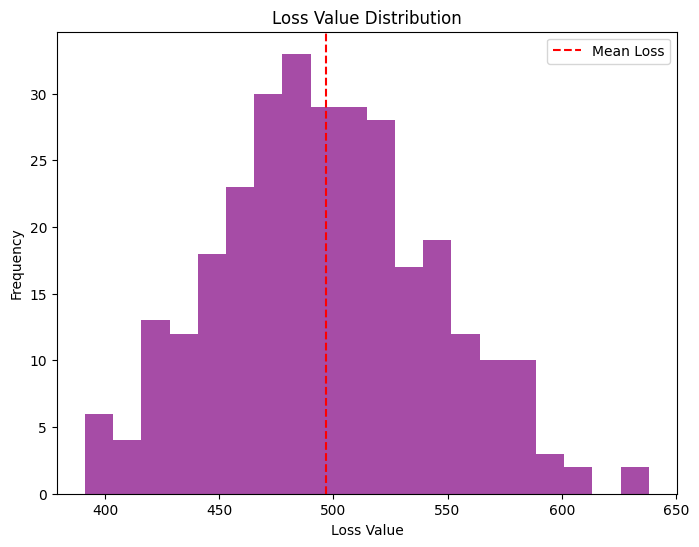

In [14]:
plt.figure(figsize=(8, 6))
plt.hist(loss_values, bins=20, alpha=0.7, color='purple')
plt.axvline(np.mean(loss_values), color='red', linestyle='dashed', label='Mean Loss')
plt.xlabel("Loss Value")
plt.ylabel("Frequency")
plt.title("Loss Value Distribution")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Number of rows (each param has two rows: one for the histogram, one for the pull)
n_params = len(param_values)
n_cols = min(n_params, 4)
n_rows = 2 * ((n_params + n_cols - 1) // n_cols)  # Each param takes two rows

fig = plt.figure(figsize=(4 * n_cols, 4 * (n_rows // 2) + 2))  # Extra space for loss plot
gs = GridSpec(n_rows + 2, n_cols, hspace=0.05)  # Adding space for loss plot

for i, (param, values) in enumerate(param_values.items()):
    row = (i // n_cols) * 2  # Find correct row
    col = i % n_cols  # Find correct column

    # Upper subplot: Parameter value histogram
    ax1 = fig.add_subplot(gs[row, col])
    ax1.hist(values, bins=20, alpha=0.7, color='blue')
    ax1.axvline(np.mean(values), color='red', linestyle='dashed', label='Mean')
    ax1.set_title(param, fontsize=10)
    ax1.legend()
    ax1.grid()

    # Lower subplot: Pulls visualization
    ax2 = fig.add_subplot(gs[row + 1, col], sharex=ax1)
    ax2.hist(pulls[param], bins=20, alpha=0.7, color='green')
    ax2.axvline(np.mean(pulls[param]), color='red', linestyle='dashed', label='Mean Pull')
    ax2.set_ylabel("Pulls", fontsize=8)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    ax2.set_ylim(-5, 5)  # Adjust y-limits for clarity
    ax2.grid()

# Loss Value Distribution (added below all parameter plots)
ax_loss = fig.add_subplot(gs[-2:, :])  # Span all columns for better visualization
ax_loss.hist(loss_values, bins=20, alpha=0.7, color='purple')
ax_loss.axvline(np.mean(loss_values), color='red', linestyle='dashed', label='Mean Loss')
ax_loss.set_xlabel("Loss Value")
ax_loss.set_ylabel("Frequency")
ax_loss.set_title("Loss Value Distribution")
ax_loss.legend()
ax_loss.grid()

# Improve layout
plt.tight_layout()
plt.show()


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_4121/2492821473.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


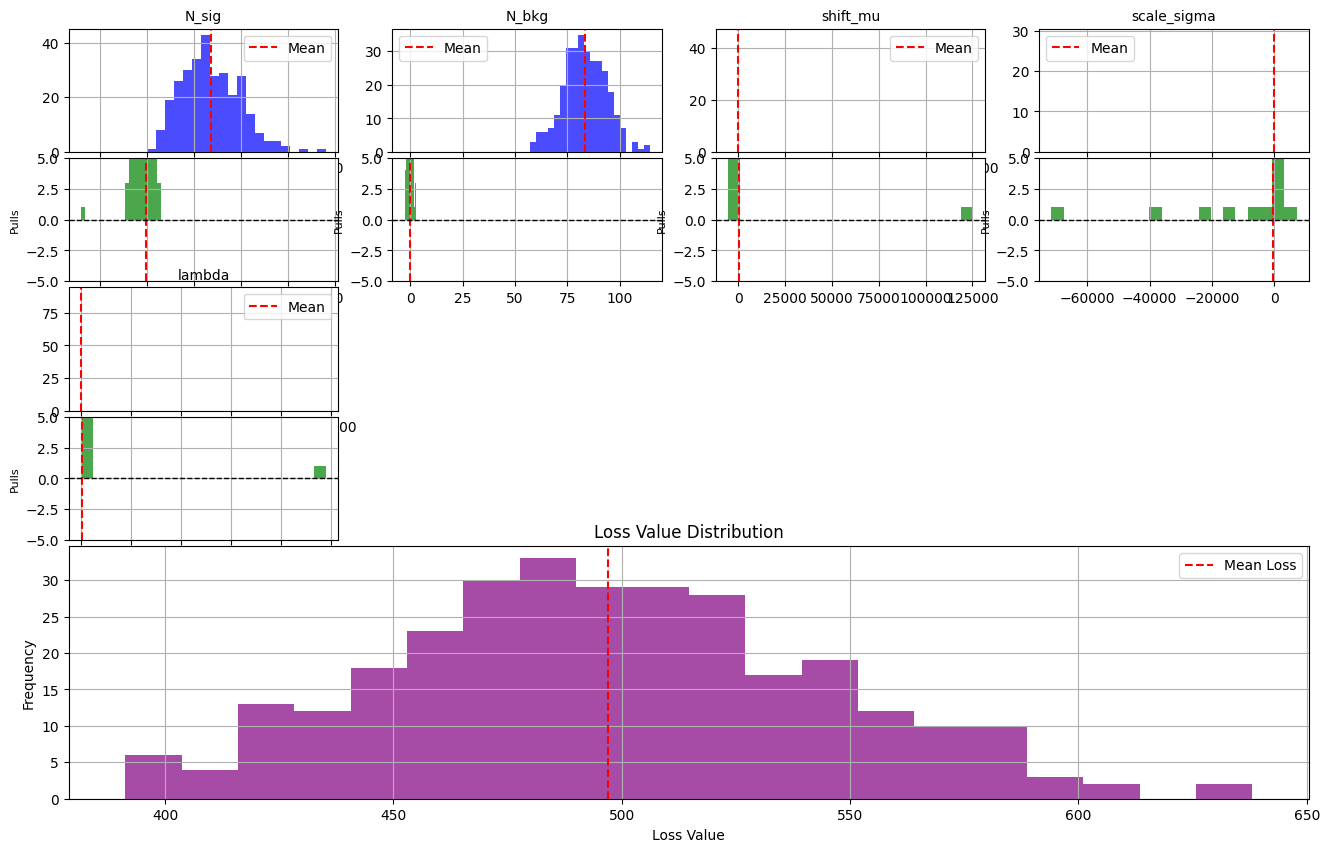

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Number of rows (each param has two rows: one for the histogram, one for the pull)
n_params = len(param_values)
n_cols = min(n_params, 4)
n_rows = 2 * ((n_params + n_cols - 1) // n_cols)  # Each param takes two rows

fig = plt.figure(figsize=(4 * n_cols, 4 * (n_rows // 2) + 2))  # Extra space for loss plot
gs = GridSpec(n_rows + 2, n_cols, hspace=0.05)  # Adding space for loss plot

for i, (param, values) in enumerate(param_values.items()):
    row = (i // n_cols) * 2  # Find correct row
    col = i % n_cols  # Find correct column

    # Upper subplot: Parameter value histogram
    ax1 = fig.add_subplot(gs[row, col])
    ax1.hist(values, bins=20, alpha=0.7, color='blue')
    ax1.axvline(np.mean(values), color='red', linestyle='dashed', label='Mean')
    ax1.set_title(param, fontsize=10)
    ax1.legend()
    ax1.grid()

    # Lower subplot: Pulls visualization
    ax2 = fig.add_subplot(gs[row + 1, col], sharex=ax1)
    ax2.hist(pulls[param], bins=20, alpha=0.7, color='green')
    ax2.axvline(np.mean(pulls[param]), color='red', linestyle='dashed', label='Mean Pull')
    ax2.set_ylabel("Pulls", fontsize=8)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    ax2.set_ylim(-5, 5)  # Adjust y-limits for clarity
    ax2.grid()

# Loss Value Distribution (added below all parameter plots)
ax_loss = fig.add_subplot(gs[-2:, :])  # Span all columns for better visualization
ax_loss.hist(loss_values, bins=20, alpha=0.7, color='purple')
ax_loss.axvline(np.mean(loss_values), color='red', linestyle='dashed', label='Mean Loss')
ax_loss.set_xlabel("Loss Value")
ax_loss.set_ylabel("Frequency")
ax_loss.set_title("Loss Value Distribution")
ax_loss.legend()
ax_loss.grid()

# Improve layout
plt.tight_layout()
plt.show()
